In [1]:
from datasets import load_dataset

num_samples_to_take = 100
ds = load_dataset("sayeed99/fashion_segmentation", split="train",streaming=True)
ds = ds.take(num_samples_to_take)

/home/FashionSeg/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds

IterableDataset({
    features: ['image', 'label'],
    num_shards: 53
})

In [3]:
sample = next(iter(ds))
sample['image'] , sample['label']

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3676x5214>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=3676x5214>)

Text(0.5, 1.0, 'Segmentation Label')

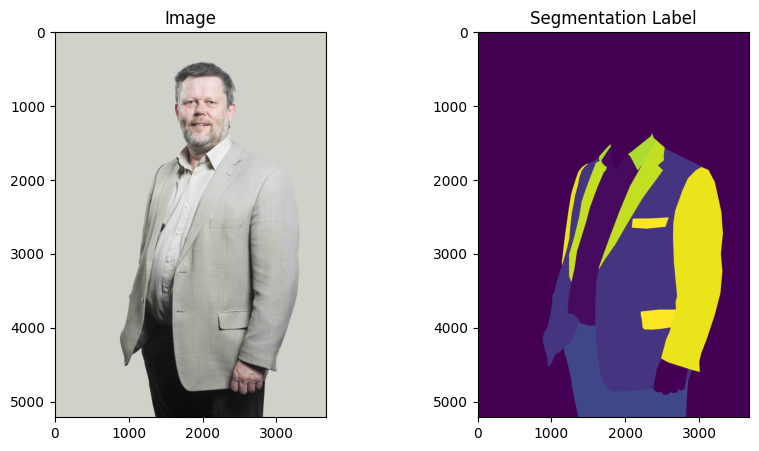

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample['image'])
ax[0].set_title('Image')    
ax[1].imshow(sample['label'])   
ax[1].set_title('Segmentation Label')

In [5]:
import random
import numpy as np

def plot_random_sample(dataset):
    skip_n = random.randint(0, num_samples_to_take - 1)
    sample = next(iter(dataset.skip(skip_n)))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(sample['image'])
    ax[0].set_title('Image')    
    ax[1].imshow(sample['label'])   
    ax[1].set_title('Segmentation Label')
    print(np.unique(np.array(sample['label'])))
    plt.show()


[ 0  2  5  7 14 19 24 29 32 33 34]


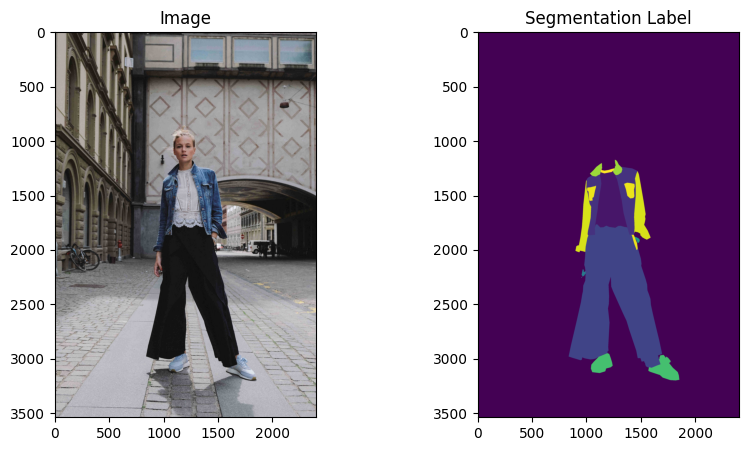

In [6]:
plot_random_sample(ds)

[ 0 11 19 25 34 45]


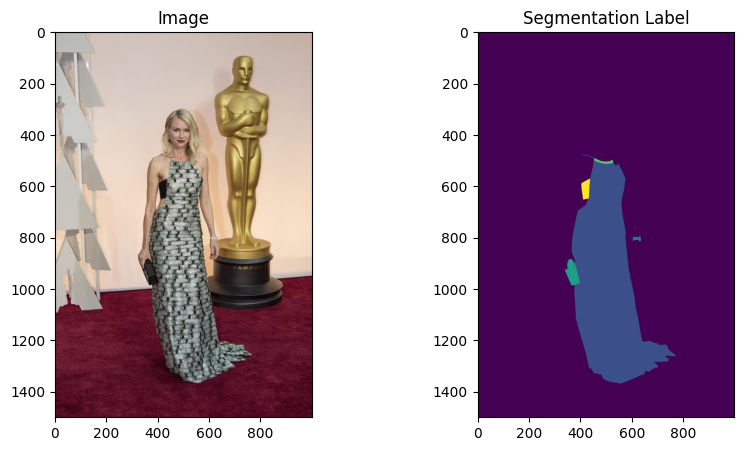

In [7]:
plot_random_sample(ds)

Class 1: 847796 pixels
Class 5: 2817303 pixels
Class 7: 883261 pixels
Class 29: 90310 pixels
Class 30: 494904 pixels
Class 32: 1566584 pixels
Class 33: 169658 pixels


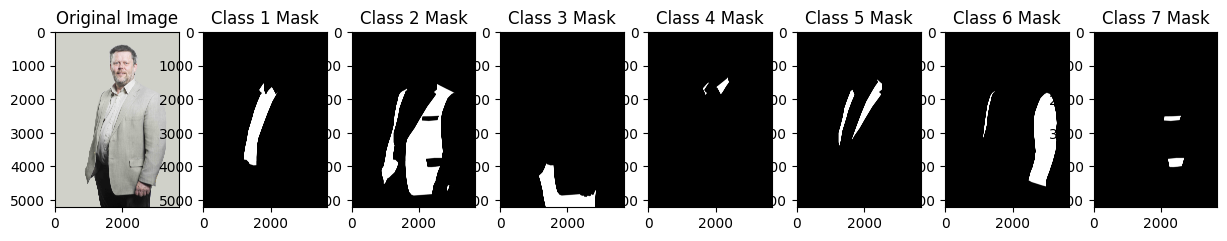

In [16]:
def extract_class_mask(mask):
    mask = np.array(mask)
    class_ids = np.unique(mask)
    
    class_ids = class_ids[class_ids != 0]

    binary_masks = []
    for class_id in class_ids:
        binary_mask = (mask == class_id).astype(np.uint8)
        binary_masks.append(binary_mask)
        print(f"Class {class_id}: {np.sum(binary_mask)} pixels")

    return binary_masks

sample = next(iter(ds))
mask = sample["label"]

binary_masks = extract_class_mask(mask)
fig, axes = plt.subplots(1, len(binary_masks)+1, figsize=(15, 5))
axes[0].imshow(sample["image"])
axes[0].set_title("Original Image")

for i, bm in enumerate(binary_masks):
    axes[i+1].imshow(bm, cmap="gray")
    axes[i+1].set_title(f"Class {i+1} Mask")

plt.show()

Class 1 point prompt: (np.int64(2942), np.int64(1625))


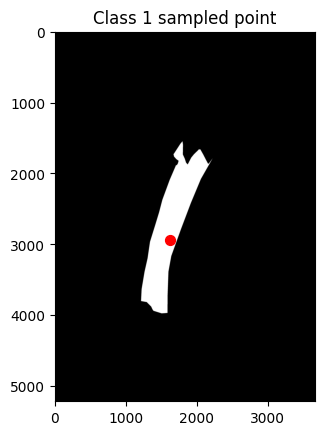

Class 2 point prompt: (np.int64(4196), np.int64(1157))


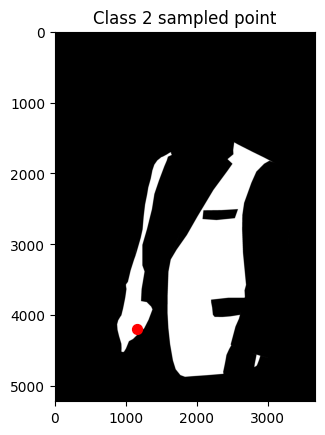

Class 3 point prompt: (np.int64(4676), np.int64(1537))


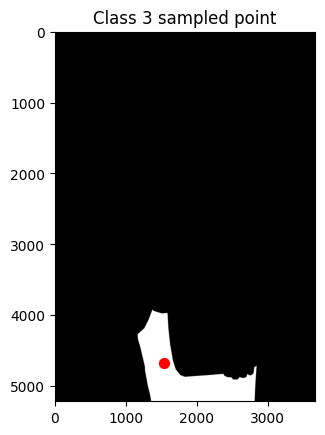

Class 4 point prompt: (np.int64(1630), np.int64(2085))


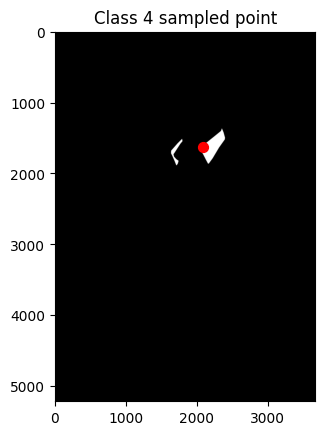

Class 5 point prompt: (np.int64(1849), np.int64(2237))


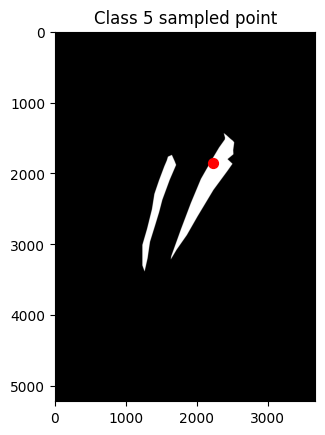

Class 6 point prompt: (np.int64(2481), np.int64(3121))


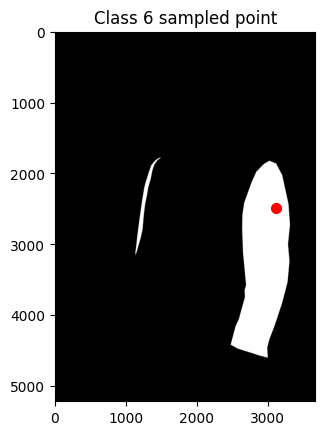

Class 7 point prompt: (np.int64(3781), np.int64(2595))


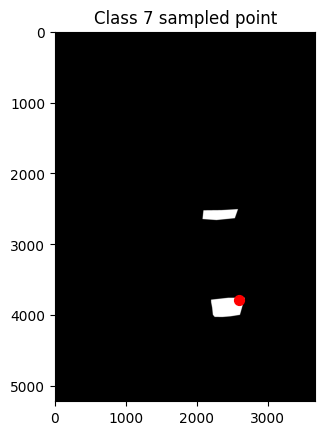

In [17]:
def sample_point_from_mask(binary_mask):
    ys, xs = np.where(binary_mask == 1)
    if len(xs) == 0:
        return None  # no foreground pixels found
    
    idx = random.randint(0, len(xs) - 1)
    y, x = ys[idx], xs[idx]
    return (y, x)

for i, mask in enumerate(binary_masks):
    point = sample_point_from_mask(mask)
    print(f"Class {i+1} point prompt:", point)

    if point is not None:
        plt.imshow(mask, cmap="gray")
        plt.scatter(point[1], point[0], c="red", s=50)
        plt.title(f"Class {i+1} sampled point")
        plt.show()

In [18]:
def extract_class_masks(mask):
    mask = np.array(mask)
    class_ids = np.unique(mask)
    class_ids = class_ids[class_ids != 0]  # exclude background
    binary_masks = [(mask == cid).astype(np.uint8) for cid in class_ids]
    return binary_masks, class_ids

def visualize_point_and_mask(sample):
    image = np.array(sample["image"])
    mask = np.array(sample["label"])
    
    binary_masks, class_ids = extract_class_masks(mask)
    
    idx = random.randint(0, len(binary_masks) - 1)
    binary_mask = binary_masks[idx]
    class_id = class_ids[idx]
    
    point = sample_point_from_mask(binary_mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(image)
    if point is not None:
        axes[1].scatter(point[1], point[0], c='red', s=60, marker='*', edgecolors='white')
    axes[1].set_title(f"Sampled Point (Class {class_id})")
    axes[1].axis("off")
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f"Binary Mask for Class {class_id}")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

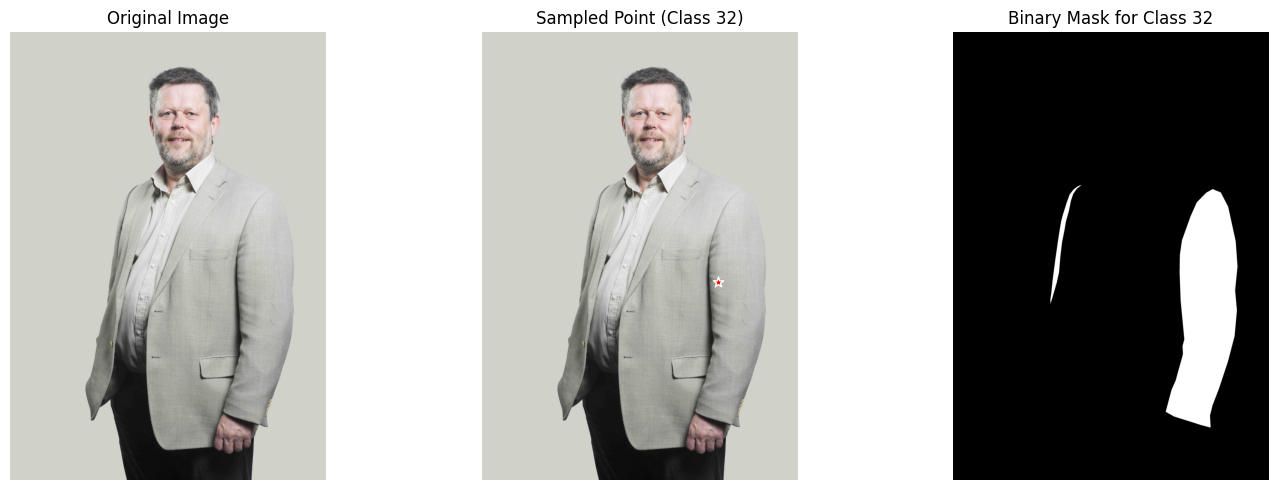

In [19]:
sample = next(iter(ds))
visualize_point_and_mask(sample)

### Convert dataset to SAM format

In [20]:
from tqdm import tqdm

In [21]:
def prepare_sam_training_data(dataset, max_samples=100):
    processed_data = []

    for i, sample in enumerate(tqdm(dataset, total=max_samples, desc="Preparing data")):
        if i >= max_samples:
            break

        image = np.array(sample["image"])
        mask = np.array(sample["label"])

        binary_masks, class_ids = extract_class_masks(mask)

        for class_id, binary_mask in zip(class_ids, binary_masks):
            point = sample_point_from_mask(binary_mask)
            if point is None:
                continue

            processed_data.append({
                "image": image,
                "mask": binary_mask,
                "point": point,
                "class_id": int(class_id)
            })

    return processed_data


In [ ]:
num_samples_to_take = 50
ds = load_dataset("sayeed99/fashion_segmentation", split="train", streaming=True,token="<fill-token>")
ds = ds.take(num_samples_to_take)

sam_data = prepare_sam_training_data(ds, max_samples=num_samples_to_take)
print(f"Prepared {len(sam_data)} training samples")

Preparing data: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]

Prepared 250 training samples


In [71]:
import os
import csv
from PIL import Image
import numpy as np

In [95]:
print("cwd:", os.getcwd()) 

cwd: /home/FashionSeg/Notebooks


In [96]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "fashion_sam_dataset")
print("data_dir:", data_dir)

data_dir: /home/FashionSeg/fashion_sam_dataset


In [97]:
assert os.path.isdir(data_dir), f"data_dir not found: {data_dir}"
print("listing top-level:", os.listdir(data_dir)[:10])
csv_path = os.path.join(data_dir, "train.csv")
assert os.path.exists(csv_path), f"train.csv not found at {csv_path}"

listing top-level: ['images', 'masks', 'train.csv']


In [98]:
df = pd.read_csv(csv_path)
print("rows in CSV:", len(df))
# Check first image and mask exist
first_img = os.path.join(data_dir, "images", df.iloc[0]["imageid"])
first_mask = os.path.join(data_dir, "masks", df.iloc[0]["maskid"])
print("first image exists:", os.path.exists(first_img))
print("first mask exists:", os.path.exists(first_mask))

rows in CSV: 250
first image exists: True
first mask exists: True


In [99]:
image_paths = [os.path.join(data_dir, "images", img) for img in df["imageid"]]
mask_paths  = [os.path.join(data_dir, "masks", msk) for msk in df["maskid"]]

In [100]:
missing_imgs = [p for p in image_paths if not os.path.exists(p)]
missing_masks = [p for p in mask_paths if not os.path.exists(p)]
if missing_imgs or missing_masks:
    raise FileNotFoundError(f"Missing images: {len(missing_imgs)}, masks: {len(missing_masks)}")

In [101]:
def create_dataset(image_paths, label_paths):
    ds = Dataset.from_dict({"image": sorted(image_paths), "label": sorted(label_paths)})
    ds = ds.cast_column("image", Image())
    ds = ds.cast_column("label", Image())
    return ds

train_dataset = create_dataset(image_paths, mask_paths)
dataset_dict = DatasetDict({"train": train_dataset})

In [ ]:
REPO = "peaceAsh/fashion-sam-dataset"  
dataset_dict.push_to_hub(REPO,token="<fill-token>")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00,  4.84ba/s]
Processing Files (1 / 1): 100%|██████████| 68.0MB / 68.0MB,  583kB/s  
New Data Upload: 100%|██████████| 2.33MB / 2.33MB,  583kB/s  
Uploading the dataset shards: 100%|██████████| 1/1 [00:07<00:00,  7.05s/ shards]


CommitInfo(commit_url='https://huggingface.co/datasets/peaceAsh/fashion-sam-dataset/commit/9d0985b8e1bb2c8df0ad428ab16c6bf8b7b27751', commit_message='Upload dataset', commit_description='', oid='9d0985b8e1bb2c8df0ad428ab16c6bf8b7b27751', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/peaceAsh/fashion-sam-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='peaceAsh/fashion-sam-dataset'), pr_revision=None, pr_num=None)

In [83]:
def save_sam_dataset(sam_data, output_dir="../fashion_sam_dataset"):
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)

    csv_path = os.path.join(output_dir, "train.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["imageid", "maskid"])

        for idx, sample in enumerate(sam_data):
            image = Image.fromarray(np.uint8(sample["image"]))
            mask = Image.fromarray(np.uint8(sample["mask"]) * 255)  # convert 0/1 → 0/255

            img_filename = f"sample_{idx}.jpg"
            mask_filename = f"mask_sample_{idx}.png"

            image.save(os.path.join(output_dir, "images", img_filename))
            mask.save(os.path.join(output_dir, "masks", mask_filename))

            writer.writerow([img_filename, mask_filename])

    print(f"Dataset saved successfully at: {output_dir}")


In [84]:
save_sam_dataset(sam_data, output_dir="../fashion_sam_dataset")

Dataset saved successfully at: ../fashion_sam_dataset
